In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import os

# Load dataset
df = pd.read_csv("../data/social_media_vs_productivity.csv")

# Define target and remove rows with missing target
target = "actual_productivity_score"
df = df[df[target].notna()].copy()

# Numerical and categorical columns
num_cols = [
    'age','daily_social_media_time','number_of_notifications','work_hours_per_day',
    'actual_productivity_score','stress_level','sleep_hours',
    'screen_time_before_sleep','breaks_during_work','coffee_consumption_per_day',
    'days_feeling_burnout_per_month','weekly_offline_hours','job_satisfaction_score'
]

# ✅ Remove perceived productivity to test behavioral-only model
if "perceived_productivity_score" in num_cols:
    num_cols.remove("perceived_productivity_score")

cat_cols = ['gender','job_type','social_platform_preference','uses_focus_apps','has_digital_wellbeing_enabled']

# X/y split
X = df[num_cols + cat_cols].copy()
y = df[target].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipelines for preprocessing
numeric_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipeline, [c for c in num_cols if c != target]),
    ("cat", categorical_pipeline, cat_cols)
], remainder='drop')

# Models
models = {
    "LinearRegression": Pipeline([("prep", preprocess), ("model", LinearRegression())]),
    "RidgeCV": Pipeline([("prep", preprocess), ("model", RidgeCV(alphas=np.logspace(-3, 3, 13)))]),
    "LassoCV": Pipeline([("prep", preprocess), ("model", LassoCV(alphas=np.logspace(-3, 1, 9), max_iter=5000, random_state=42))]),
    "DecisionTree": Pipeline([("prep", preprocess), ("model", DecisionTreeRegressor(random_state=42))]),
    "RandomForest": Pipeline([("prep", preprocess), ("model", RandomForestRegressor(
        n_estimators=300, max_depth=20, min_samples_split=5, min_samples_leaf=2,
        max_features="sqrt", bootstrap=False, random_state=42))]),
    "GradientBoosting": Pipeline([("prep", preprocess), ("model", GradientBoostingRegressor(random_state=42))])
}

# --- Hold-out test performance ---
rows = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    rows.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

results_behavioral = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
print("Hold-out Test Results:")
print(results_behavioral)

# --- Cross-validation performance ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rows = []
for name, pipe in models.items():
    r2_scores = cross_val_score(pipe, X, y, scoring="r2", cv=cv, n_jobs=-1)
    mae_scores = cross_val_score(pipe, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
    rmse_scores = cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    cv_rows.append({
        "Model": name,
        "R2 (mean)":  r2_scores.mean(),
        "R2 (std)":   r2_scores.std(),
        "MAE (mean)": -mae_scores.mean(),
        "RMSE (mean)": -rmse_scores.mean()
    })

cv_behavioral = pd.DataFrame(cv_rows).sort_values("RMSE (mean)").reset_index(drop=True)
print("\n5-Fold Cross Validation Results:")
print(cv_behavioral)

# --- Feature importance for Gradient Boosting ---
best_pipe = models["GradientBoosting"]
best_pipe.fit(X_train, y_train)

preproc = best_pipe.named_steps["prep"]
num_features = [c for c in num_cols if c != target]
cat_ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
cat_features = list(cat_ohe.get_feature_names_out(cat_cols))
all_features = num_features + cat_features

importances = best_pipe.named_steps["model"].feature_importances_
feat_imp_behavioral = pd.Series(importances, index=all_features).sort_values(ascending=False)

print("\nTop 10 Feature Importances:")
print(feat_imp_behavioral.head(10))

# Save outputs
os.makedirs("../reports/tables", exist_ok=True)
results_behavioral.to_csv("../reports/tables/model_behavioral_holdout.csv", index=False)
cv_behavioral.to_csv("../reports/tables/model_behavioral_cv.csv", index=False)
feat_imp_behavioral.to_csv("../reports/tables/feature_importances_behavioral.csv", header=["importance"])


Hold-out Test Results:
              Model        R2       MAE      RMSE
0  GradientBoosting  0.718353  0.771818  1.007296
1           LassoCV  0.710754  0.789328  1.020795
2  LinearRegression  0.710228  0.789736  1.021721
3           RidgeCV  0.710222  0.789784  1.021732
4      RandomForest  0.707930  0.795551  1.025764
5      DecisionTree  0.423154  1.105269  1.441565

5-Fold Cross Validation Results:
              Model  R2 (mean)  R2 (std)  MAE (mean)  RMSE (mean)
0  GradientBoosting   0.716589  0.007150    0.773660     1.002331
1           LassoCV   0.709034  0.006983    0.789956     1.015618
2           RidgeCV   0.709031  0.006932    0.790097     1.015625
3  LinearRegression   0.709027  0.006938    0.790072     1.015631
4      RandomForest   0.705935  0.006771    0.795506     1.021012
5      DecisionTree   0.408980  0.018272    1.110777     1.447343

Top 10 Feature Importances:
job_satisfaction_score            0.992363
sleep_hours                       0.001353
weekly_offline_h

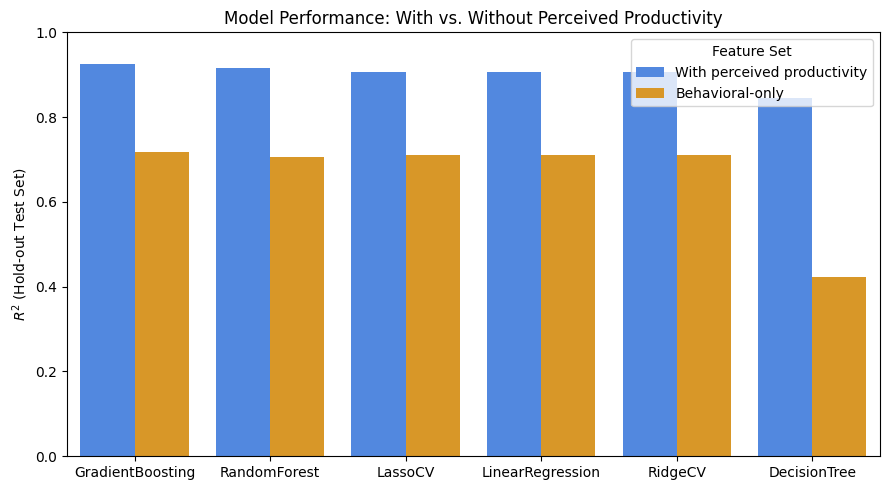

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Hold-out R2 results before and after removing 'perceived_productivity_score'
before = {
    "Model": ["GradientBoosting", "RandomForest", "LassoCV", "LinearRegression", "RidgeCV", "DecisionTree"],
    "R2": [0.925, 0.917, 0.906, 0.906, 0.906, 0.845]
}

after = {
    "Model": ["GradientBoosting", "RandomForest", "LassoCV", "LinearRegression", "RidgeCV", "DecisionTree"],
    "R2": [0.718, 0.706, 0.711, 0.710, 0.710, 0.423]
}

df_before = pd.DataFrame(before)
df_before["Setting"] = "With perceived productivity"
df_after = pd.DataFrame(after)
df_after["Setting"] = "Behavioral-only"

df_combined = pd.concat([df_before, df_after])

# Make output directory
os.makedirs("../reports/figures", exist_ok=True)

# Plot
plt.figure(figsize=(9, 5))
sns.barplot(
    data=df_combined,
    x="Model",
    y="R2",
    hue="Setting",
    palette=["#3b82f6", "#f59e0b"]
)
plt.title("Model Performance: With vs. Without Perceived Productivity")
plt.ylabel("$R^2$ (Hold-out Test Set)")
plt.xlabel("")
plt.legend(title="Feature Set", loc="upper right")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../reports/figures/model_behavioral_comparison.png", dpi=300)
plt.show()
